In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [2]:
# Step 1: Data Loading
data = pd.read_csv('data.csv')

# Extract features and target
X = data.drop(columns=['Target']).values
y = data['Target'].values

In [3]:
# Step 2: Data Preprocessing
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [4]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [5]:
X_train_tensor.shape

torch.Size([23964, 10])

First Type of the model created

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.3, weight_decay=0.001):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='tanh')
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out)
        out = self.fc(out)  # hn has shape (num_layers * num_directions, batch, hidden_size)
        return out

2nd Type of model

In [7]:
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.5, weight_decay=0.001):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(hidden_size, output_size)
        self.weight_decay = weight_decay
        
    def forward(self, x):
        out, _ = self.rnn(x)
        # out = F.relu(out)  # Apply nonlinearity (e.g., ReLU) to the output of the RNN layer
        out = self.dropout(out)  # Apply dropout
        out = self.fc(out)  # hn has shape (num_layers * num_directions, batch, hidden_size)
        return out
    
    def l2_regularization_loss(self):
        l2_reg = torch.tensor(0.0, device=self.fc.weight.device)
        for param in self.parameters():
            l2_reg += torch.norm(param, p=2)
        return self.weight_decay * l2_reg

In [8]:
input_size = X_train_tensor.shape[1]
hidden_size = 10
output_size = 1
model = RNN(input_size, hidden_size, output_size)

In [9]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming `model` is already defined
model.to(device)  # Move model to GPU if CUDA is available

# Define loss function and optimizer
criterion = nn.MSELoss().to(device)  # Move loss function to GPU if CUDA is available
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Move input and target tensors to GPU if CUDA is available
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

# Define other parameters
num_epochs = 3000
batch_size = 64

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Define test loader
test_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_losses = []
test_losses = []

In [64]:
# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU if CUDA is available
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU if CUDA is available
            outputs = model(inputs)
            regularization_loss = model.l2_regularization_loss()
            loss = criterion(outputs.squeeze(), targets) + regularization_loss
            test_loss += loss.item() * inputs.size(0)  # Accumulate test loss
            
        test_loss /= len(test_loader.dataset)  # Calculate average test loss
        test_losses.append(test_loss)

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_loss:.4f}')
    

  3%|▎         | 100/3000 [02:23<1:10:37,  1.46s/it]

Epoch [100/3000], Train Loss: 0.9677, Test Loss: 0.1436


  7%|▋         | 200/3000 [04:50<1:09:05,  1.48s/it]

Epoch [200/3000], Train Loss: 0.3274, Test Loss: 0.1352


 10%|█         | 300/3000 [07:22<1:05:04,  1.45s/it]

Epoch [300/3000], Train Loss: 0.0928, Test Loss: 0.1287


 13%|█▎        | 400/3000 [09:49<1:03:22,  1.46s/it]

Epoch [400/3000], Train Loss: 0.3114, Test Loss: 0.1299


 17%|█▋        | 500/3000 [12:08<45:41,  1.10s/it]  

Epoch [500/3000], Train Loss: 0.1758, Test Loss: 0.1282


 20%|██        | 600/3000 [14:25<58:03,  1.45s/it]

Epoch [600/3000], Train Loss: 0.1396, Test Loss: 0.1306


 23%|██▎       | 700/3000 [16:42<56:53,  1.48s/it]

Epoch [700/3000], Train Loss: 0.0501, Test Loss: 0.1251


 27%|██▋       | 800/3000 [19:08<52:31,  1.43s/it]

Epoch [800/3000], Train Loss: 0.2983, Test Loss: 0.1281


 30%|███       | 900/3000 [21:35<51:20,  1.47s/it]

Epoch [900/3000], Train Loss: 1.1156, Test Loss: 0.1311


 33%|███▎      | 1000/3000 [24:01<49:07,  1.47s/it]

Epoch [1000/3000], Train Loss: 0.0425, Test Loss: 0.1281


 37%|███▋      | 1100/3000 [26:28<46:53,  1.48s/it]

Epoch [1100/3000], Train Loss: 0.0808, Test Loss: 0.1241


 40%|████      | 1200/3000 [28:51<42:28,  1.42s/it]

Epoch [1200/3000], Train Loss: 0.0452, Test Loss: 0.1331


 43%|████▎     | 1300/3000 [31:13<41:06,  1.45s/it]

Epoch [1300/3000], Train Loss: 0.0280, Test Loss: 0.1277


 47%|████▋     | 1400/3000 [33:40<39:26,  1.48s/it]

Epoch [1400/3000], Train Loss: 0.1871, Test Loss: 0.1223


 50%|█████     | 1500/3000 [36:08<36:44,  1.47s/it]

Epoch [1500/3000], Train Loss: 0.0317, Test Loss: 0.1293


 53%|█████▎    | 1600/3000 [38:36<34:44,  1.49s/it]

Epoch [1600/3000], Train Loss: 0.0503, Test Loss: 0.1338


 57%|█████▋    | 1700/3000 [41:03<32:13,  1.49s/it]

Epoch [1700/3000], Train Loss: 0.2636, Test Loss: 0.1255


 60%|██████    | 1800/3000 [43:31<29:27,  1.47s/it]

Epoch [1800/3000], Train Loss: 0.1623, Test Loss: 0.1265


 63%|██████▎   | 1900/3000 [45:56<27:15,  1.49s/it]

Epoch [1900/3000], Train Loss: 0.0490, Test Loss: 0.1229


 67%|██████▋   | 2000/3000 [48:23<24:17,  1.46s/it]

Epoch [2000/3000], Train Loss: 0.0493, Test Loss: 0.1247


 70%|███████   | 2100/3000 [51:02<22:50,  1.52s/it]

Epoch [2100/3000], Train Loss: 0.0418, Test Loss: 0.1238


 73%|███████▎  | 2200/3000 [53:37<20:19,  1.52s/it]

Epoch [2200/3000], Train Loss: 0.0701, Test Loss: 0.1279


 77%|███████▋  | 2300/3000 [56:12<18:08,  1.55s/it]

Epoch [2300/3000], Train Loss: 0.1360, Test Loss: 0.1245


 80%|████████  | 2400/3000 [58:48<15:07,  1.51s/it]

Epoch [2400/3000], Train Loss: 0.0592, Test Loss: 0.1233


 83%|████████▎ | 2500/3000 [1:01:26<14:13,  1.71s/it]

Epoch [2500/3000], Train Loss: 0.0884, Test Loss: 0.1227


 87%|████████▋ | 2600/3000 [1:03:59<09:46,  1.47s/it]

Epoch [2600/3000], Train Loss: 0.5595, Test Loss: 0.1201


 90%|█████████ | 2700/3000 [1:06:28<07:23,  1.48s/it]

Epoch [2700/3000], Train Loss: 0.0271, Test Loss: 0.1267


 93%|█████████▎| 2800/3000 [1:08:58<05:18,  1.59s/it]

Epoch [2800/3000], Train Loss: 0.0251, Test Loss: 0.1278


 97%|█████████▋| 2900/3000 [1:11:27<02:28,  1.49s/it]

Epoch [2900/3000], Train Loss: 0.0413, Test Loss: 0.1226


100%|██████████| 3000/3000 [1:13:48<00:00,  1.48s/it]

Epoch [3000/3000], Train Loss: 0.2978, Test Loss: 0.1265


In [10]:
import matplotlib.pyplot as plt

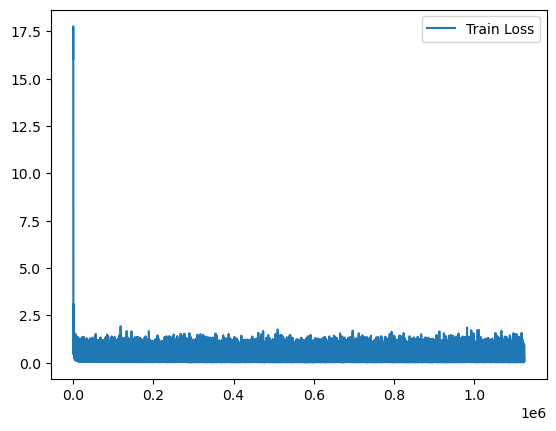

In [71]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.legend()

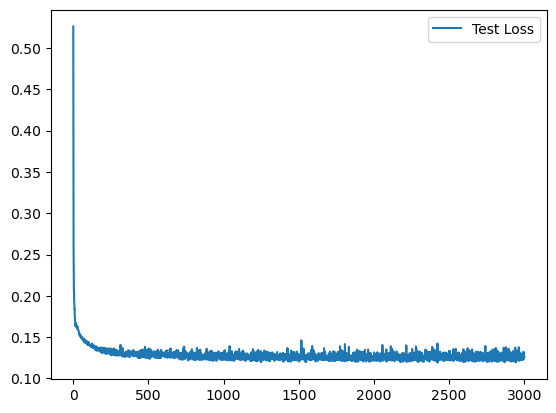

In [70]:
plt.figure()
plt.plot(test_losses, label='Test Loss')
plt.legend()

In [11]:
import numpy as np

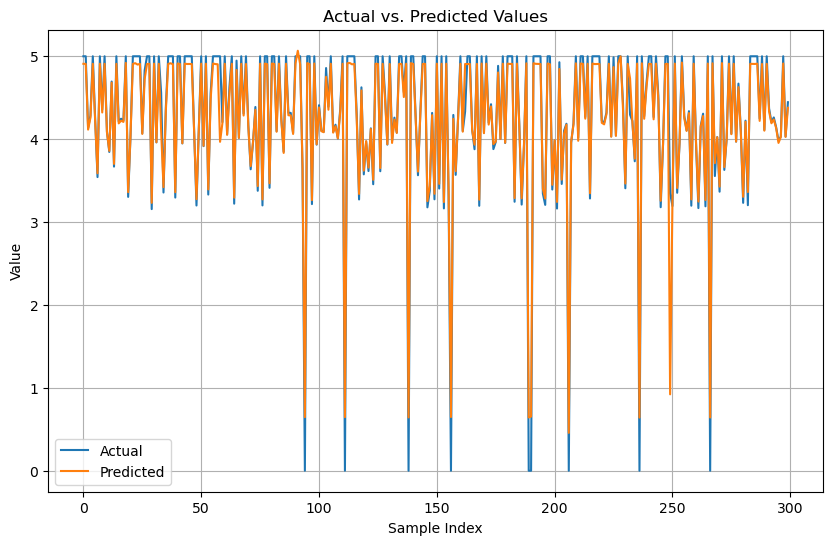

In [90]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Lists to store actual and predicted values
y_actual = []
y_predicted = []

# Iterate over test data and collect predictions
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        y_actual.extend(targets.cpu().numpy().tolist())
        y_predicted.extend(outputs.squeeze().cpu().numpy().tolist())

# Convert lists to numpy arrays
y_actual = np.array(y_actual)
y_predicted = np.array(y_predicted)

# Ploting actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_actual[0:300], label='Actual')
plt.plot(y_predicted[0:300], label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
torch.save(model.state_dict(), 'rnn_mpc.pt')

In [92]:
model.eval()

RNN(
  (rnn): RNN(10, 10, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [19]:
X_rnd = torch.rand(1,1,10).to(device)
traced_model = torch.jit.trace(model.forward, X_rnd)
traced_model.save('traced_rnn_mpc_model.pt')

In [16]:
X_train_tensor.shape

torch.Size([23964, 10])